### CNN 이미지 분류 모델
- 이미지 데이터셋 준비
    * torchvision의 내장 데이터셋 활용 CIFAR10
- 이미지 분류 모델
    * 커스텀 CNN 구현

[1] 모듈 로딩 및 데이터 준비 <hr>

In [239]:
# 모듈 로딩
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision.datasets import CIFAR10        # torchvision 내장 데이터셋 관련 모듈
from torchvision.transforms import ToTensor     # torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader         # 데이터셋 관련 모듈 로딩
import matplotlib.pyplot as plt
from torchinfo import summary

In [240]:
# 데이터 로딩
DIR_PATH = '/Users/anhyojun/WorkSpace/LocalData/cifa10'

# Pytorch의 Dataset 형태 로딩
cifarDS = CIFAR10(DIR_PATH, train=True, download=True, transform=ToTensor())

Files already downloaded and verified


In [241]:
# Dataset의 속성 확인
print(f'cifarDS.classes : {cifarDS.classes}')
print(f'cifarDS.class_to_idx : {cifarDS.class_to_idx}')
print(f'cifarDS.data.shape : {cifarDS.data.shape}')
print(f'len(cifarDS.targets) : {len(cifarDS.targets)}')

cifarDS.classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarDS.class_to_idx : {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
cifarDS.data.shape : (50000, 32, 32, 3)
len(cifarDS.targets) : 50000


[2] 데이터 로더 <hr>
- 학습 시 배치크기만큼 데이터와 라벨/타겟을 로딩

In [242]:
BATCH_SIZE = 1

cifarDL = DataLoader(cifarDS, batch_size = BATCH_SIZE)

torch.Size([32, 32, 3])


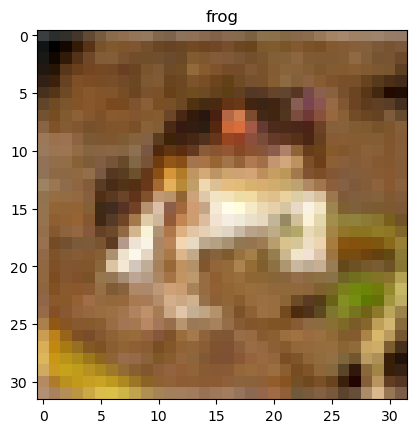

In [243]:
for data, target in cifarDL:
    data = data
    target = target
    break

INDEX = 0

data1 = data[[INDEX]].squeeze().permute(1,2,0)
print(data1.shape)
name = [key for key, value in cifarDS.class_to_idx.items() if value == target[INDEX].item()][0]
plt.title(name)
plt.imshow(data1) # (height, width, channel) 형태로 줘야 함
plt.show()

[3] 커스텀 모델 설계 및 정의 <hr>
- 모델 목적 : 이미지 분류 모델
- 학습 방법 : 지도학습 > 분류 > 다중분류 (10개)
- 클래스 이름 : ImageMCF
- 클래스 구조 : 특징추출부분 => CNN + 학습부분 FC
- 부모 클래스 : nn.Module

In [244]:
class ImageMCF(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        self.in_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.p_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        # 학습 관련 층
        self.hd_layer = nn.Linear(in_features=15*15*10, out_features=50)
        self.out_layer = nn.Linear(in_features=50, out_features=10)

    # 전방향/순방향 학습 메서드
    def forward(self, input):
        # 합성곱 계층
        output = self.in_layer(input)
        print(f'[output1] {output.shape}')
        output = F.relu(output)
        print(f'[output2] {output.shape}')

        # 풀링 계층
        output = self.p_layer(output)
        print(f'[output3] {output.shape}')

        # 은닉 계층
        output = output.view(output.shape[0], -1)
        print(f'[output4] {output.shape}')
        output = F.relu(self.hd_layer(output))
        print(f'[output5] {output.shape}')

        # 출력 계층
        output = self.out_layer(output)
        print(f'[output6] {output.shape}')

        return output


In [245]:
# [테스트] 모델 인스턴스 생성
m = ImageMCF()

summary(m)

Layer (type:depth-idx)                   Param #
ImageMCF                                 --
├─Conv2d: 1-1                            280
├─MaxPool2d: 1-2                         --
├─Linear: 1-3                            112,550
├─Linear: 1-4                            510
Total params: 113,340
Trainable params: 113,340
Non-trainable params: 0

In [246]:
# [테스트] Dataset, DataLoader
for data, target in cifarDL:
    print(f'[target] => {target}')
    print(data.shape)
    pre = m(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[output1] torch.Size([1, 10, 30, 30])
[output2] torch.Size([1, 10, 30, 30])
[output3] torch.Size([1, 10, 15, 15])
[output4] torch.Size([1, 2250])
[output5] torch.Size([1, 50])
[output6] torch.Size([1, 10])
pre => tensor([8])


In [247]:
for name, param in m.named_parameters():
    print(f'>>[{name}]----------\n{param.shape}')

>>[in_layer.weight]----------
torch.Size([10, 3, 3, 3])
>>[in_layer.bias]----------
torch.Size([10])
>>[hd_layer.weight]----------
torch.Size([50, 2250])
>>[hd_layer.bias]----------
torch.Size([50])
>>[out_layer.weight]----------
torch.Size([10, 50])
>>[out_layer.bias]----------
torch.Size([10])


In [248]:
class ImageMCF2(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 학습 관련 층
        self.hd_layer = nn.Linear(in_features=10*15*15, out_features=50)
        self.out_layer = nn.Linear(in_features=50, out_features=10)

    # 전방향/순방향 학습 메서드
    def forward(self, input):
        # 이미지 특징 맵 추출
        output = self.cnn_layer(input)
        print(f'[cnn_layer output] {output.shape}')

        # 4D -> 2D (샘플수, 피쳐수)
        output = output.view(output.shape[0], -1)
        print(f'[view output] {output.shape}')

        output = F.relu(self.hd_layer(output))
        print(f'[hd_layer output5] {output.shape}')

        # 출력 계층
        output = self.out_layer(output)
        print(f'[out_layer output6] {output.shape}')

        return output

In [249]:
# [테스트] 모델 인스턴스 생성
m2 = ImageMCF2()

summary(m2)

Layer (type:depth-idx)                   Param #
ImageMCF2                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Linear: 1-2                            112,550
├─Linear: 1-3                            510
Total params: 113,340
Trainable params: 113,340
Non-trainable params: 0

In [250]:
# [테스트] Dataset, DataLoader
for data, target in cifarDL:
    print(f'[target] => {target}')
    print(data.shape)
    pre = m2(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer output] torch.Size([1, 10, 15, 15])
[view output] torch.Size([1, 2250])
[hd_layer output5] torch.Size([1, 50])
[out_layer output6] torch.Size([1, 10])
pre => tensor([6])


In [251]:
for name, param in m2.named_parameters():
    print(f'>>[{name}]----------\n{param.shape}')

>>[cnn_layer.0.weight]----------
torch.Size([10, 3, 3, 3])
>>[cnn_layer.0.bias]----------
torch.Size([10])
>>[hd_layer.weight]----------
torch.Size([50, 2250])
>>[hd_layer.bias]----------
torch.Size([50])
>>[out_layer.weight]----------
torch.Size([10, 50])
>>[out_layer.bias]----------
torch.Size([10])


In [252]:
class ImageMCF3(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # (1 x 3 x 32 x 32) => (1, 10, 15, 15)

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=30, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # (1, 10, 15, 15) => (1, 30, 6, 6)

        # 학습 관련 층
        self.hd_layer = nn.Linear(in_features=30*6*6, out_features=50)
        self.out_layer = nn.Linear(in_features=50, out_features=10)

    # 전방향/순방향 학습 메서드
    def forward(self, input):
        # 이미지 특징 맵 추출
        output = self.cnn_layer(input)
        print(f'[cnn_layer output] {output.shape}')

        output = self.cnn_layer2(output)
        print(f'[cnn_layer output] {output.shape}')

        # 4D -> 2D (샘플수, 피쳐수)
        output = output.view(output.shape[0], -1)
        print(f'[view output] {output.shape}')

        output = F.relu(self.hd_layer(output))
        print(f'[hd_layer output5] {output.shape}')

        # 출력 계층
        output = self.out_layer(output)
        print(f'[out_layer output6] {output.shape}')

        return output

In [253]:
# [테스트] 모델 인스턴스 생성
m3 = ImageMCF3()

summary(m3)

Layer (type:depth-idx)                   Param #
ImageMCF3                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,730
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Linear: 1-3                            54,050
├─Linear: 1-4                            510
Total params: 57,570
Trainable params: 57,570
Non-trainable params: 0

In [254]:
# [테스트] Dataset, DataLoader
for data, target in cifarDL:
    print(f'[target] => {target}')
    print(data.shape)
    pre = m3(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer output] torch.Size([1, 10, 15, 15])
[cnn_layer output] torch.Size([1, 30, 6, 6])
[view output] torch.Size([1, 1080])
[hd_layer output5] torch.Size([1, 50])
[out_layer output6] torch.Size([1, 10])
pre => tensor([6])


In [255]:
for name, param in m3.named_parameters():
    print(f'>>[{name}]----------\n{param.shape}')

>>[cnn_layer.0.weight]----------
torch.Size([10, 3, 3, 3])
>>[cnn_layer.0.bias]----------
torch.Size([10])
>>[cnn_layer2.0.weight]----------
torch.Size([30, 10, 3, 3])
>>[cnn_layer2.0.bias]----------
torch.Size([30])
>>[hd_layer.weight]----------
torch.Size([50, 1080])
>>[hd_layer.bias]----------
torch.Size([50])
>>[out_layer.weight]----------
torch.Size([10, 50])
>>[out_layer.bias]----------
torch.Size([10])
